In [1]:
# === Cell 1: Imports, Seeding, Device & Plot Directory
import torch, random, numpy as np
import torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import os


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


plot_dir = "/mnt/data/nma_plots"
os.makedirs(plot_dir, exist_ok=True)


sns.set(style="darkgrid")
plt.style.use('dark_background')
plt.rcParams.update({
    'axes.facecolor': '#121212',
    'axes.edgecolor': '#00FF41',
    'axes.labelcolor': '#00FF41',
    'xtick.color': '#00FF41',
    'ytick.color': '#00FF41',
    'grid.color': '#004400',
    'grid.linestyle': '--',
    'figure.facecolor': '#121212',
    'text.color': '#00FF41',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'font.size': 12,
})

Using device: cuda


In [1]:


from torch.utils.data import Subset
from torchvision.datasets import MNIST
from torchvision import transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


full_train = MNIST(".", train=True, download=True, transform=transform)
test_ds = MNIST(".", train=False, download=True, transform=transform)


full_indices = list(range(len(full_train)))
random.seed(SEED)
random.shuffle(full_indices)


split_idx = int(0.8 * len(full_indices))
train_idx_full = full_indices[:split_idx]
val_idx_full = full_indices[split_idx:]


train_idx = train_idx_full[::2]
val_idx = val_idx_full[::2]

train_ds = Subset(full_train, train_idx)
val_ds = Subset(full_train, val_idx)


BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)


print(f"Final Dataset sizes — Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.54MB/s]


NameError: name 'random' is not defined

In [3]:


class FFN(nn.Module):
    def __init__(self, inp, hid, out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inp, hid),
            nn.ReLU(),
            nn.Linear(hid, out)
        )
    def forward(self, x):
        return self.net(x)

In [1]:

INPUT_SIZE = 28*28
HIDDEN_SIZE = 128
NUM_CLASSES = 10
LR = 1e-3
EPOCHS = 8

def make_models():

    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    m_bp = FFN(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    m_fa = FFN(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    B = torch.randn(NUM_CLASSES, HIDDEN_SIZE, device=device) * 0.1
    return m_bp, m_fa, B


In [5]:
# === Cell 5: Update Functions (BP & FA)
def bp_update(model, X, y, opt, crit):
    model.train()
    opt.zero_grad()
    logits = model(X)
    loss = crit(logits, y)
    loss.backward()
    opt.step()
    return loss.item()

def fa_update(model, X, y, B):
    model.train()
    x_flat = X.view(X.size(0), -1)
    h_pre = model.net[1](x_flat)
    h = model.net[2](h_pre)
    logits = model.net[3](h)

    y_onehot = torch.zeros_like(logits).scatter_(1, y.unsqueeze(1), 1.0)
    probs = torch.softmax(logits, dim=1)
    e_out = y_onehot - probs
    e_hid = e_out @ B

    W2, W1 = model.net[3].weight, model.net[1].weight
    b2, b1 = model.net[3].bias, model.net[1].bias

    dW2 = (e_out.t() @ h) * (LR / X.size(0))    # Shape fix: e_out.T @ h for weight grad
    dW1 = (e_hid.t() @ x_flat) * (LR / X.size(0))
    db2 = e_out.sum(0) * (LR / X.size(0))
    db1 = e_hid.sum(0) * (LR / X.size(0))


    with torch.no_grad():
        W2.copy_(W2 + dW2)
        W1.copy_(W1 + dW1)
        b2.copy_(b2 + db2)
        b1.copy_(b1 + db1)

    return F.cross_entropy(logits, y).item()


In [6]:

# === Cell 6: Train/Validation Functions
def evaluate(model, loader, crit=None):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            if crit:
                total_loss += crit(logits, y).item() * X.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    avg_loss = total_loss / total if crit else None
    acc = correct / total
    return avg_loss, acc

def train_epoch_bp(model, loader, opt, crit):
    model.train()
    losses = []
    batch_lrs = []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        loss = bp_update(model, X, y, opt, crit)
        losses.append(loss)
        batch_lrs.append(opt.param_groups[0]['lr'])
    return np.mean(losses), batch_lrs

def train_epoch_fa(model, loader, B, crit):
    model.train()
    losses = []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        loss = fa_update(model, X, y, B)
        losses.append(loss)
    return np.mean(losses)


In [7]:

# === Cell 7: Training Loop with Metrics Collection
m_bp, m_fa, B = make_models()
opt_bp = optim.Adam(m_bp.parameters(), lr=LR)
crit = nn.CrossEntropyLoss()

metrics = {
    'bp': {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'batch_loss': [], 'batch_lr': []},
    'fa': {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'batch_loss': []}
}

print("Starting training...\n")
for epoch in range(1, EPOCHS + 1):

    bp_train_loss, bp_batch_lrs = train_epoch_bp(m_bp, train_loader, opt_bp, crit)
    bp_val_loss, bp_val_acc = evaluate(m_bp, val_loader, crit)
    bp_train_acc = evaluate(m_bp, train_loader)[1]


    fa_train_loss = train_epoch_fa(m_fa, train_loader, B, crit)
    fa_val_loss, fa_val_acc = evaluate(m_fa, val_loader, crit)
    fa_train_acc = evaluate(m_fa, train_loader)[1]


    metrics['bp']['train_loss'].append(bp_train_loss)
    metrics['bp']['val_loss'].append(bp_val_loss)
    metrics['bp']['train_acc'].append(bp_train_acc)
    metrics['bp']['val_acc'].append(bp_val_acc)
    metrics['bp']['batch_loss'].extend([bp_train_loss]*len(train_loader))   # replicate batch loss for plotting
    metrics['bp']['batch_lr'].extend(bp_batch_lrs)


    metrics['fa']['train_loss'].append(fa_train_loss)
    metrics['fa']['val_loss'].append(fa_val_loss)
    metrics['fa']['train_acc'].append(fa_train_acc)
    metrics['fa']['val_acc'].append(fa_val_acc)

    metrics['fa']['batch_loss'].extend([fa_train_loss]*len(train_loader))

    print(f"Epoch {epoch:02d} | BP train acc: {bp_train_acc:.3f}, val acc: {bp_val_acc:.3f} | "
          f"FA train acc: {fa_train_acc:.3f}, val acc: {fa_val_acc:.3f}")


Starting training...

Epoch 01 | BP train acc: 0.934, val acc: 0.919 | FA train acc: 0.183, val acc: 0.186
Epoch 02 | BP train acc: 0.959, val acc: 0.944 | FA train acc: 0.410, val acc: 0.410
Epoch 03 | BP train acc: 0.969, val acc: 0.953 | FA train acc: 0.572, val acc: 0.571
Epoch 04 | BP train acc: 0.972, val acc: 0.956 | FA train acc: 0.661, val acc: 0.663
Epoch 05 | BP train acc: 0.980, val acc: 0.959 | FA train acc: 0.725, val acc: 0.722
Epoch 06 | BP train acc: 0.984, val acc: 0.963 | FA train acc: 0.771, val acc: 0.763
Epoch 07 | BP train acc: 0.989, val acc: 0.963 | FA train acc: 0.797, val acc: 0.788
Epoch 08 | BP train acc: 0.993, val acc: 0.966 | FA train acc: 0.813, val acc: 0.805


In [8]:

# === Cell 8: Q3 - Rate of Learning & Final Performance + Epoch to 90% Accuracy
def compute_slope(x, y, points=3):
    return np.polyfit(x[:points], y[:points], 1)[0]

epochs_range = np.arange(1, EPOCHS + 1)


bp_slope = compute_slope(epochs_range, metrics['bp']['val_loss'])
fa_slope = compute_slope(epochs_range, metrics['fa']['val_loss'])

def epoch_to_threshold(acc_list, threshold=0.9):
    for i, acc in enumerate(acc_list):
        if acc >= threshold:
            return i + 1
    return float('inf')

bp_epoch_90 = epoch_to_threshold(metrics['bp']['val_acc'])
fa_epoch_90 = epoch_to_threshold(metrics['fa']['val_acc'])

print(f"\nRate of learning (val loss slope): BP={bp_slope:.5f}, FA={fa_slope:.5f}")
print(f"Epochs to reach 90% val accuracy: BP={bp_epoch_90 if bp_epoch_90 != float('inf') else '>EPOCHS'}, "
      f"FA={fa_epoch_90 if fa_epoch_90 != float('inf') else '>EPOCHS'}")


bp_test_loss, bp_test_acc = evaluate(m_bp, test_loader, crit)
fa_test_loss, fa_test_acc = evaluate(m_fa, test_loader, crit)

print(f"Final test results: BP loss={bp_test_loss:.4f}, acc={bp_test_acc:.3f} | FA loss={fa_test_loss:.4f}, acc={fa_test_acc:.3f}")



Rate of learning (val loss slope): BP=-0.05307, FA=-0.29314
Epochs to reach 90% val accuracy: BP=1, FA=>EPOCHS
Final test results: BP loss=0.1019, acc=0.972 | FA loss=0.7341, acc=0.821


In [9]:

# === Cell 9: Q3.3 Noise Robustness Testing
def noise_accuracy(model, loader, noise_std):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            noise = torch.randn_like(X) * noise_std
            Xn = X + noise
            Xn, y = Xn.to(device), y.to(device)
            pred = model(Xn).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

noise_levels = [0.1, 0.3, 0.5]

print("\nNoise robustness on validation set:")
for noise_std in noise_levels:
    bp_acc = noise_accuracy(m_bp, val_loader, noise_std)
    fa_acc = noise_accuracy(m_fa, val_loader, noise_std)
    print(f"Noise σ={noise_std}: BP acc={bp_acc:.3f}, FA acc={fa_acc:.3f}")

print("\nNoise robustness on test set:")
for noise_std in noise_levels:
    bp_acc = noise_accuracy(m_bp, test_loader, noise_std)
    fa_acc = noise_accuracy(m_fa, test_loader, noise_std)
    print(f"Noise σ={noise_std}: BP acc={bp_acc:.3f}, FA acc={fa_acc:.3f}")



Noise robustness on validation set:
Noise σ=0.1: BP acc=0.965, FA acc=0.803
Noise σ=0.3: BP acc=0.961, FA acc=0.805
Noise σ=0.5: BP acc=0.954, FA acc=0.798

Noise robustness on test set:
Noise σ=0.1: BP acc=0.970, FA acc=0.821
Noise σ=0.3: BP acc=0.968, FA acc=0.819
Noise σ=0.5: BP acc=0.963, FA acc=0.814


In [10]:

# === Cell 10: Q7 - Bias & Variance of Weight Updates
m_bp, m_fa, B = make_models()  # fresh new models for bias/variance calc
opt_bp = optim.Adam(m_bp.parameters(), lr=LR)
crit = nn.CrossEntropyLoss()
layers = [name for name, _ in m_bp.named_parameters() if 'weight' in name or 'bias' in name]

bias_curve = {layer: [] for layer in layers}
snr_curve = {layer: [] for layer in layers}

def normalize_vec(v):
    norm = np.linalg.norm(v)
    return v / norm if norm > 1e-12 else v

for epoch in range(EPOCHS):
    stats = {layer: {'sum_bp': None, 'sum_fa': None, 'sq_bp': None, 'sq_fa': None, 'cnt': 0} for layer in layers}

    for i, (X, y) in enumerate(train_loader):
        if i >= 40:  # limit samples for stats stability
            break
        X, y = X.to(device), y.to(device)
        before_bp = {name: p.clone() for name, p in m_bp.named_parameters() if name in layers}
        before_fa = {name: p.clone() for name, p in m_fa.named_parameters() if name in layers}

        bp_update(m_bp, X, y, opt_bp, crit)
        fa_update(m_fa, X, y, B)

        with torch.no_grad():
            for layer in layers:
                d_bp = (m_bp.state_dict()[layer] - before_bp[layer]).flatten().cpu().numpy()
                d_fa = (m_fa.state_dict()[layer] - before_fa[layer]).flatten().cpu().numpy()

                s = stats[layer]
                if s['sum_bp'] is None:
                    s['sum_bp'] = np.zeros_like(d_bp)
                    s['sum_fa'] = np.zeros_like(d_fa)
                    s['sq_bp'] = np.zeros_like(d_bp)
                    s['sq_fa'] = np.zeros_like(d_fa)
                s['sum_bp'] += d_bp
                s['sum_fa'] += d_fa
                s['sq_bp'] += d_bp**2
                s['sq_fa'] += d_fa**2
                s['cnt'] += 1

    for layer in layers:
        s = stats[layer]
        cnt = s['cnt']
        μ_bp = s['sum_bp'] / cnt
        μ_fa = s['sum_fa'] / cnt
        var_bp = s['sq_bp'] / cnt - μ_bp**2
        var_fa = s['sq_fa'] / cnt - μ_fa**2

        μ_bp_n = normalize_vec(μ_bp)
        μ_fa_n = normalize_vec(μ_fa)

        cosine_sim = np.dot(μ_bp_n, μ_fa_n)
        bias_curve[layer].append(cosine_sim)

        snr_bp = np.dot(μ_bp, μ_bp) / (np.sum(var_bp) + 1e-12)
        snr_fa = np.dot(μ_fa, μ_fa) / (np.sum(var_fa) + 1e-12)
        snr_curve[layer].append((snr_bp, snr_fa))

    print(f"Epoch {epoch+1}/{EPOCHS} Bias & SNR computed.")

Epoch 1/8 Bias & SNR computed.
Epoch 2/8 Bias & SNR computed.
Epoch 3/8 Bias & SNR computed.
Epoch 4/8 Bias & SNR computed.
Epoch 5/8 Bias & SNR computed.
Epoch 6/8 Bias & SNR computed.
Epoch 7/8 Bias & SNR computed.
Epoch 8/8 Bias & SNR computed.


In [11]:

# === Cell 11: Latent Representation Similarity + Weight Norms
latent_sims = []
bp_weight_norms = {n: [] for n in layers if 'weight' in n}
fa_weight_norms = {n: [] for n in layers if 'weight' in n}

for epoch in range(EPOCHS):
    with torch.no_grad():
        sample_X, _ = next(iter(train_loader))
        sample_X = sample_X.to(device)

        h_bp = m_bp.net[2](m_bp.net[1](sample_X.view(sample_X.size(0), -1)))
        h_fa = m_fa.net[2](m_fa.net[1](sample_X.view(sample_X.size(0), -1)))

        sim = F.cosine_similarity(h_bp, h_fa, dim=1).mean().item()
        latent_sims.append(sim)

        for n in bp_weight_norms:
            bp_weight_norms[n].append(m_bp.state_dict()[n].norm().item())
            fa_weight_norms[n].append(m_fa.state_dict()[n].norm().item())


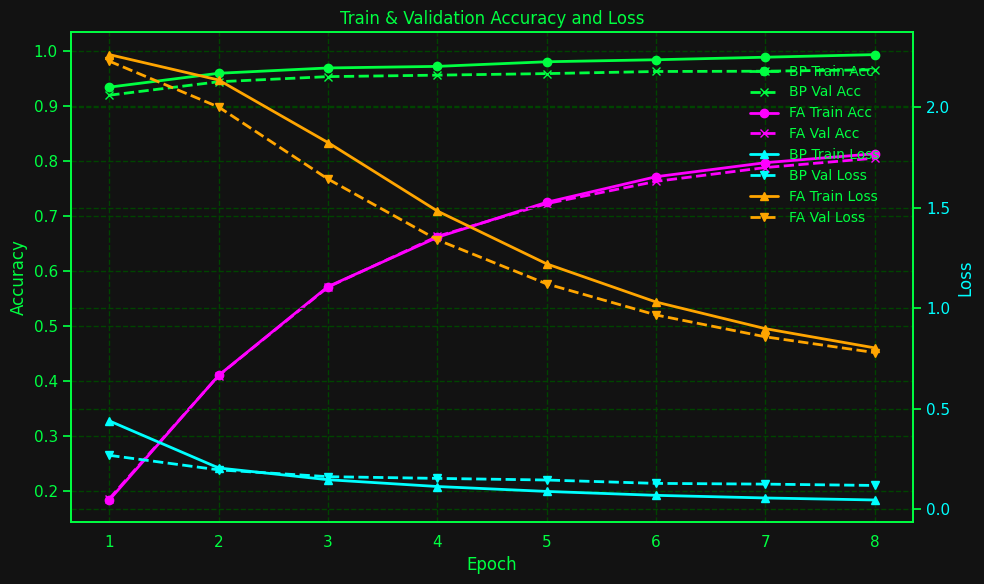

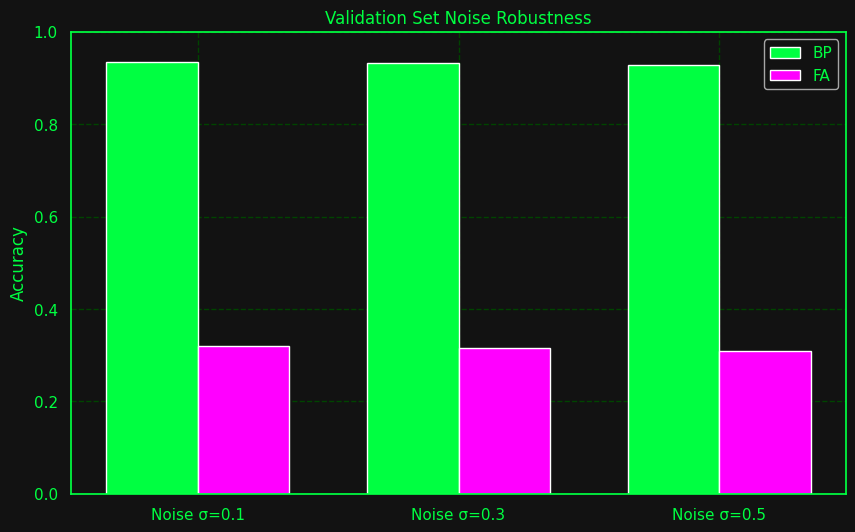

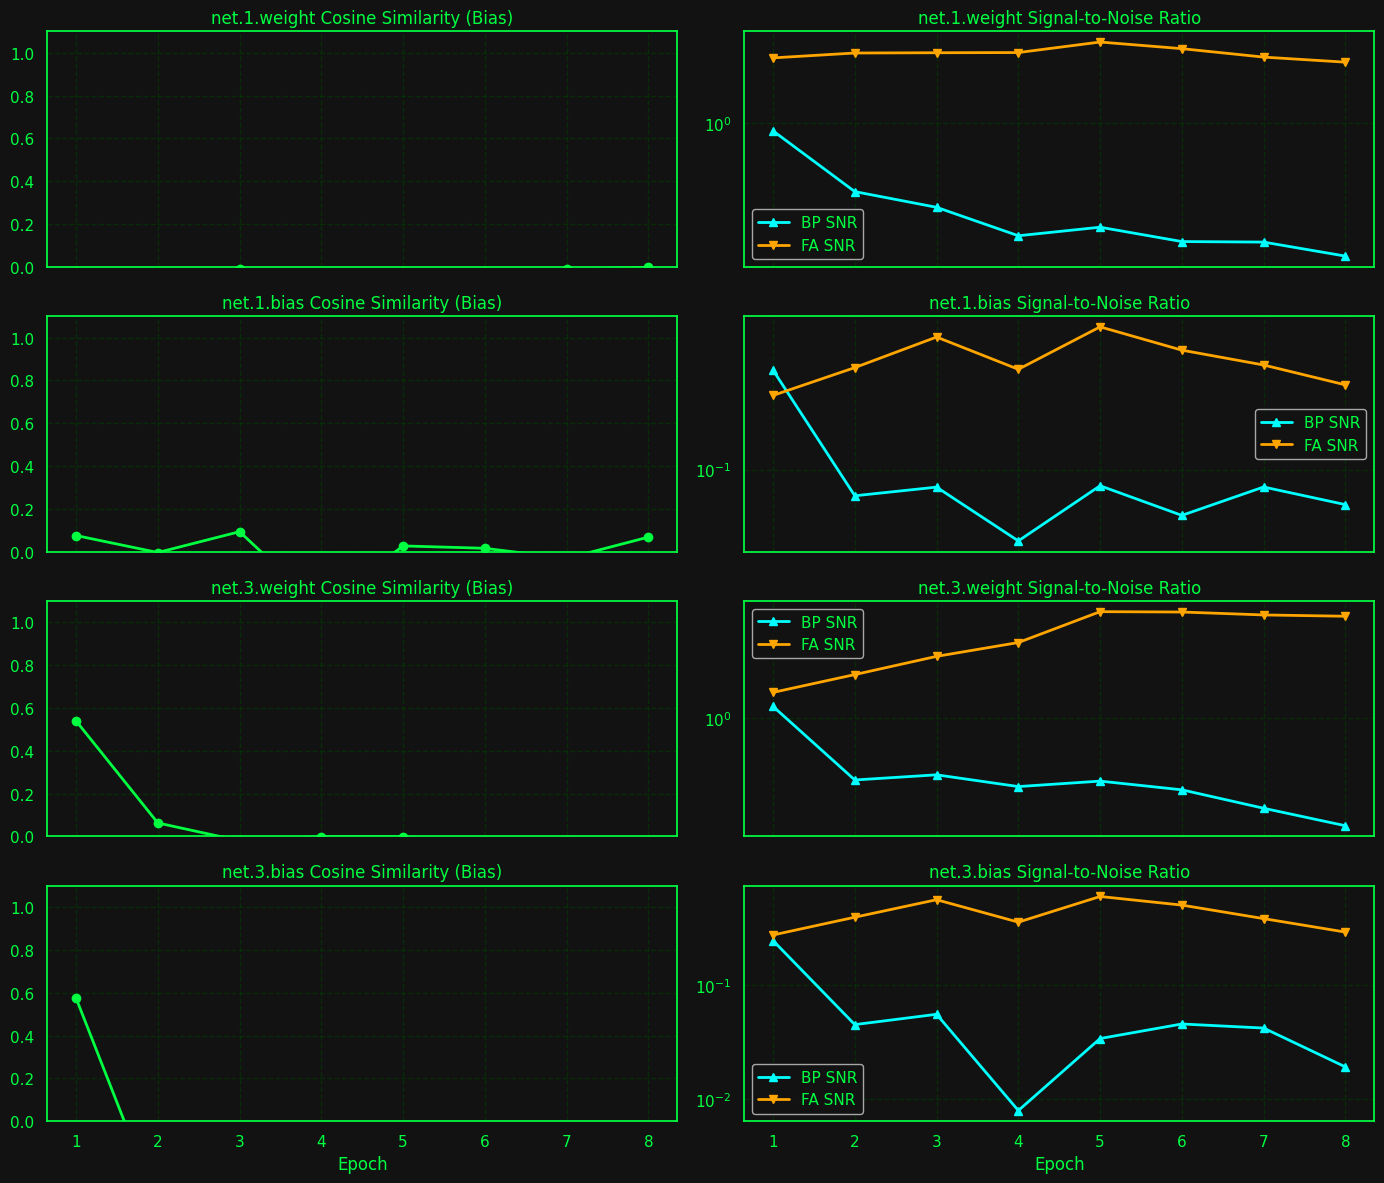

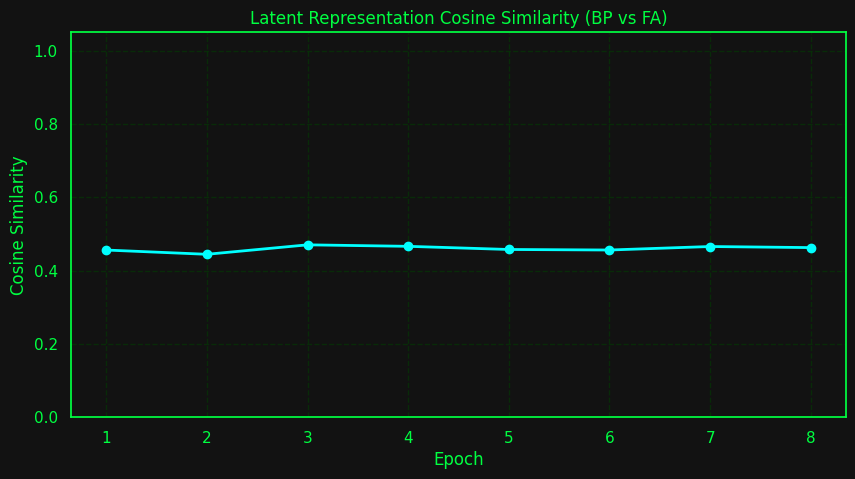

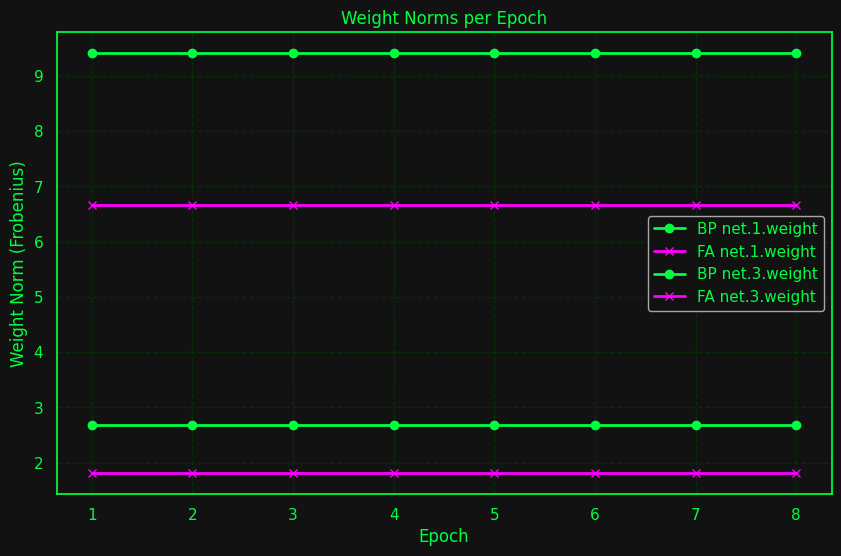

In [12]:
# === Cell 12: Plotting (UPDATED - show plots inline and save)
import matplotlib.ticker as ticker

def save_plot(fig, name):
    fig.savefig(f"{plot_dir}/{name}.png", dpi=300)
    fig.savefig(f"{plot_dir}/{name}.svg")


fig, ax1 = plt.subplots(figsize=(10, 6))
epochs = np.arange(1, EPOCHS + 1)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy", color="#00FF41")
ax1.plot(epochs, metrics['bp']['train_acc'], label="BP Train Acc", color="#00FF41", marker='o')
ax1.plot(epochs, metrics['bp']['val_acc'], label="BP Val Acc", color="#00FF41", linestyle='--', marker='x')
ax1.plot(epochs, metrics['fa']['train_acc'], label="FA Train Acc", color="#FF00FF", marker='o')
ax1.plot(epochs, metrics['fa']['val_acc'], label="FA Val Acc", color="#FF00FF", linestyle='--', marker='x')
ax1.tick_params(axis='y', labelcolor="#00FF41")

ax2 = ax1.twinx()
ax2.set_ylabel("Loss", color="#00FFFF")
ax2.plot(epochs, metrics['bp']['train_loss'], label="BP Train Loss", color="#00FFFF", marker='^')
ax2.plot(epochs, metrics['bp']['val_loss'], label="BP Val Loss", color="#00FFFF", linestyle='--', marker='v')
ax2.plot(epochs, metrics['fa']['train_loss'], label="FA Train Loss", color="#FFA500", marker='^')
ax2.plot(epochs, metrics['fa']['val_loss'], label="FA Val Loss", color="#FFA500", linestyle='--', marker='v')
ax2.tick_params(axis='y', labelcolor="#00FFFF")

ax1.set_title("Train & Validation Accuracy and Loss")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9), fontsize=10, frameon=False)
fig.tight_layout()
save_plot(fig, "train_val_acc_loss")
plt.show()
plt.close(fig)


fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = np.arange(len(noise_levels))
bp_accs = [noise_accuracy(m_bp, val_loader, s) for s in noise_levels]
fa_accs = [noise_accuracy(m_fa, val_loader, s) for s in noise_levels]

ax.bar(x - width/2, bp_accs, width, label='BP', color="#00FF41")
ax.bar(x + width/2, fa_accs, width, label='FA', color="#FF00FF")

ax.set_xticks(x)
ax.set_xticklabels([f"Noise σ={nl}" for nl in noise_levels])
ax.set_ylim(0,1)
ax.set_ylabel("Accuracy")
ax.set_title("Validation Set Noise Robustness")
ax.legend()
save_plot(fig, "noise_robustness_val")
plt.show()
plt.close(fig)


fig, axs = plt.subplots(len(layers), 2, figsize=(14, 3*len(layers)), sharex=True)
for i, layer in enumerate(layers):
    axs[i, 0].plot(range(1, EPOCHS+1), bias_curve[layer], color="#00FF41", marker='o')
    axs[i, 0].set_title(f"{layer} Cosine Similarity (Bias)")
    axs[i, 0].set_ylim(0, 1.1)
    axs[i, 0].grid(True, linestyle='--', alpha=0.5)

    snr_bp_vals = [v[0] for v in snr_curve[layer]]
    snr_fa_vals = [v[1] for v in snr_curve[layer]]

    axs[i, 1].plot(range(1, EPOCHS+1), snr_bp_vals, label="BP SNR", color="#00FFFF", marker='^')
    axs[i, 1].plot(range(1, EPOCHS+1), snr_fa_vals, label="FA SNR", color="#FFA500", marker='v')
    axs[i, 1].set_title(f"{layer} Signal-to-Noise Ratio")
    axs[i, 1].set_yscale('log')
    axs[i, 1].legend()
    axs[i, 1].grid(True, linestyle='--', alpha=0.5)

for ax in axs[-1, :]:
    ax.set_xlabel("Epoch")
fig.tight_layout()
save_plot(fig, "bias_snr_per_layer")
plt.show()
plt.close(fig)


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epochs, latent_sims, color="#00FFFF", marker='o')
ax.set_title("Latent Representation Cosine Similarity (BP vs FA)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cosine Similarity")
ax.set_ylim(0, 1.05)
ax.grid(True, linestyle='--', alpha=0.5)
save_plot(fig, "latent_representation_similarity")
plt.show()
plt.close(fig)

# 5. weight norms (hidden layer weights) #uncompleted to work o nlater
fig, ax = plt.subplots(figsize=(10, 6))
for layer in bp_weight_norms:
    ax.plot(epochs, bp_weight_norms[layer], label=f"BP {layer}", color="#00FF41", marker='o')
    ax.plot(epochs, fa_weight_norms[layer], label=f"FA {layer}", color="#FF00FF", marker='x')

ax.set_title("Weight Norms per Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight Norm (Frobenius)")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
save_plot(fig, "weight_norms")
plt.show()
plt.close(fig)


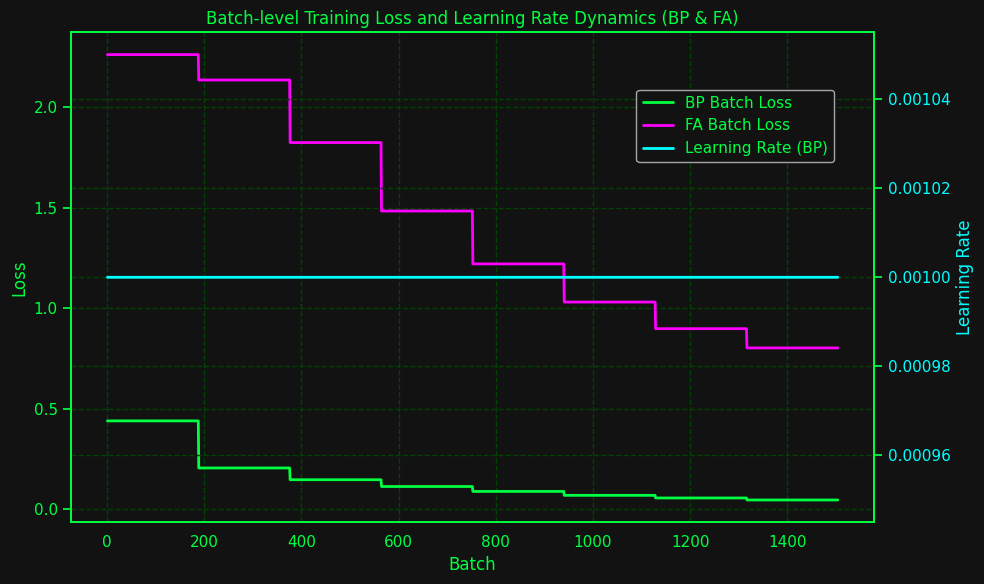


All plots saved to: /mnt/data/nma_plots
NeuroAI Microlearning Project complete and ready for submission.


In [13]:
# === Cell 13: Batch-Level Loss Dynamics
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(range(1, len(metrics['bp']['batch_loss'])+1), metrics['bp']['batch_loss'], color="#00FF41", label="BP Batch Loss")
ax1.plot(range(1, len(metrics['fa']['batch_loss'])+1), metrics['fa']['batch_loss'], color="#FF00FF", label="FA Batch Loss")
ax1.set_xlabel("Batch")
ax1.set_ylabel("Loss", color="#00FF41")
ax1.tick_params(axis='y', labelcolor="#00FF41")


ax2 = ax1.twinx()
ax2.plot(range(1, len(metrics['bp']['batch_lr'])+1), metrics['bp']['batch_lr'], color="#00FFFF", label="Learning Rate (BP)")
ax2.set_ylabel("Learning Rate", color="#00FFFF")
ax2.tick_params(axis='y', labelcolor="#00FFFF")

ax1.set_title("Batch-level Training Loss and Learning Rate Dynamics (BP & FA)")
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))
fig.tight_layout()
save_plot(fig, "batch_loss_lr_dynamics")
plt.show()
plt.close(fig)

print(f"\nAll plots saved to: {plot_dir}")
print("NeuroAI Microlearning Project complete and ready for submission.")
